In [19]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acovf, acf, pacf
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kstest
import scipy.stats as st

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [20]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (12, 7)
pd.set_option('display.float_format','{:.4f}'.format)

# Pobranie i przekształcenie danych

[*********************100%***********************]  1 of 1 completed


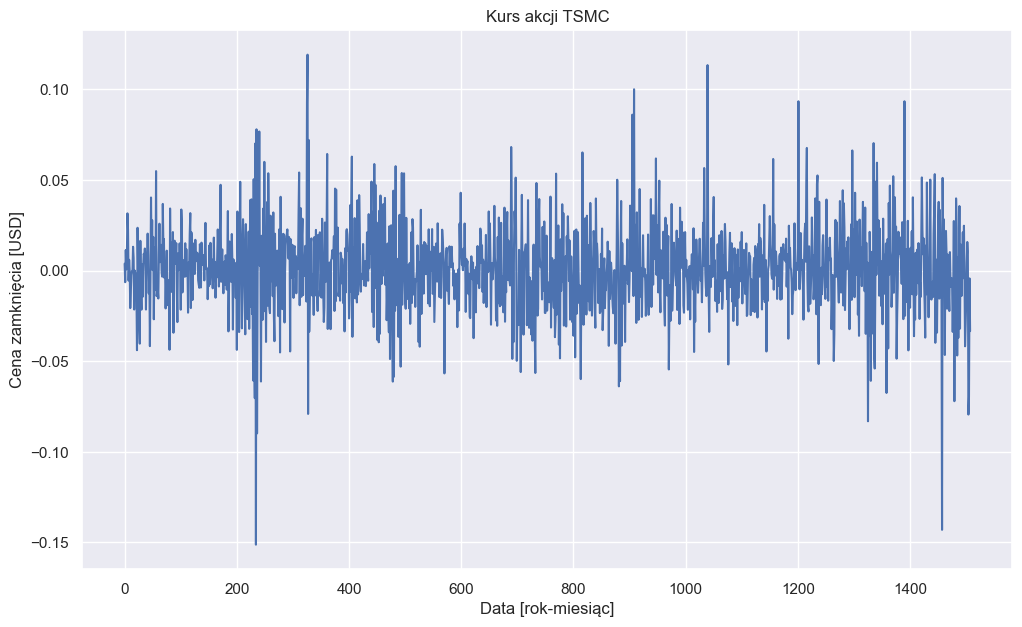

In [21]:
tsmc_data = yf.download('TSM', period = '6y')
tsmc_data = tsmc_data['Close']

log_ret_tsmc = np.log(tsmc_data / tsmc_data.shift(1)).dropna()
log_ret_tsmc = np.ravel(log_ret_tsmc)

plt.plot(log_ret_tsmc)
plt.title('Kurs akcji TSMC')
plt.ylabel('Cena zamknięcia [USD]')
plt.xlabel('Data [rok-miesiąc]')
plt.grid(True)
plt.show()

[*********************100%***********************]  1 of 1 completed


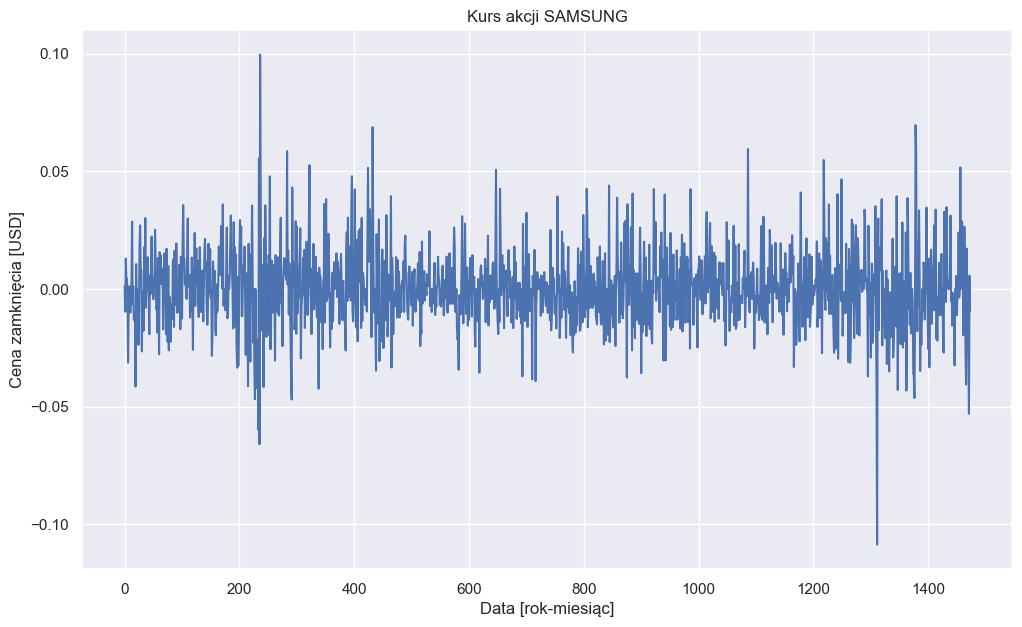

In [22]:
smg_data = yf.download('005930.KS', period = '6y')
smg_data = smg_data['Close']

log_ret_smg = np.log(smg_data / smg_data.shift(1)).dropna()
log_ret_smg = np.ravel(log_ret_smg)

plt.plot(log_ret_smg)
plt.title('Kurs akcji SAMSUNG')
plt.ylabel('Cena zamknięcia [USD]')
plt.xlabel('Data [rok-miesiąc]')
plt.grid(True)
plt.show()

## Dane z TSMC są większe, dlatego trzeba zbiór danych przyciąć

In [23]:
print(len(log_ret_tsmc), len(log_ret_smg))
log_ret_tsmc = log_ret_tsmc[:len(log_ret_smg)]
print(len(log_ret_tsmc), len(log_ret_smg))

1508 1474
1474 1474


Przeanalizowaliśmy już te dane z osobna i wiemy, że mogą one pochodzić z rozkładu t-Studenta z 5-cioma stopniami swobody. Możemy tego użyć do utworzenia rozkładu dwuwymiarowego

In [35]:
data_comb = np.column_stack((log_ret_tsmc, log_ret_smg))
data_comb

array([[ 0.0037835 ,  0.00107114],
       [-0.00639303, -0.00968251],
       [ 0.0113372 ,  0.01288974],
       ...,
       [ 0.01020392, -0.05307742],
       [-0.00570525,  0.00562326],
       [-0.00886831, -0.00938974]])

# Definicja Portfel

In [36]:
class Portfel:
    """_summary_
    """
    def __init__(self, data_comb, odset_tsmc:float=.5) -> None:
        self.odset_tsmc = odset_tsmc
        self.odset_smg = 1 - odset_tsmc
        self.log_tsmc = data_comb[:,0]
        self.log_smg = data_comb[:,1]
    
    @property
    def mean(self):
        return self.odset_tsmc*self.log_tsmc.mean() + self.odset_smg*self.log_smg.mean()
    
    @property
    def var(self):
        return self.odset_tsmc*self.odset_tsmc*self.log_tsmc.var() + self.odset_smg*self.odset_smg*self.log_smg.var() + \
            2*self.odset_smg*self.odset_tsmc*self.log_smg.std()* self.log_tsmc.std()*np.corrcoef(self.log_smg[1:],
                                                     self.log_tsmc[1:])[1,0]

    def quantile(self, q):
        return np.quantile(self.log_tsmc[1:], q)*self.odset_tsmc + np.quantile(self.log_smg[1:], q)*self.odset_smg

    def __getitem__(self, key):
        return self.log_tsmc[1:][key]*self.odset_tsmc + \
            self.log_smg[1:][key]*self.odset_smg

In [38]:
space = np.linspace(0, 1, 100)
means = []
vars = []
for i in space:
    p = Portfel(data_comb, odset_tsmc=i)
    means.append(p.mean)
    vars.append(p.var)

Text(0.5, 0, 'Odsetek akcji tsmc w portfelu')

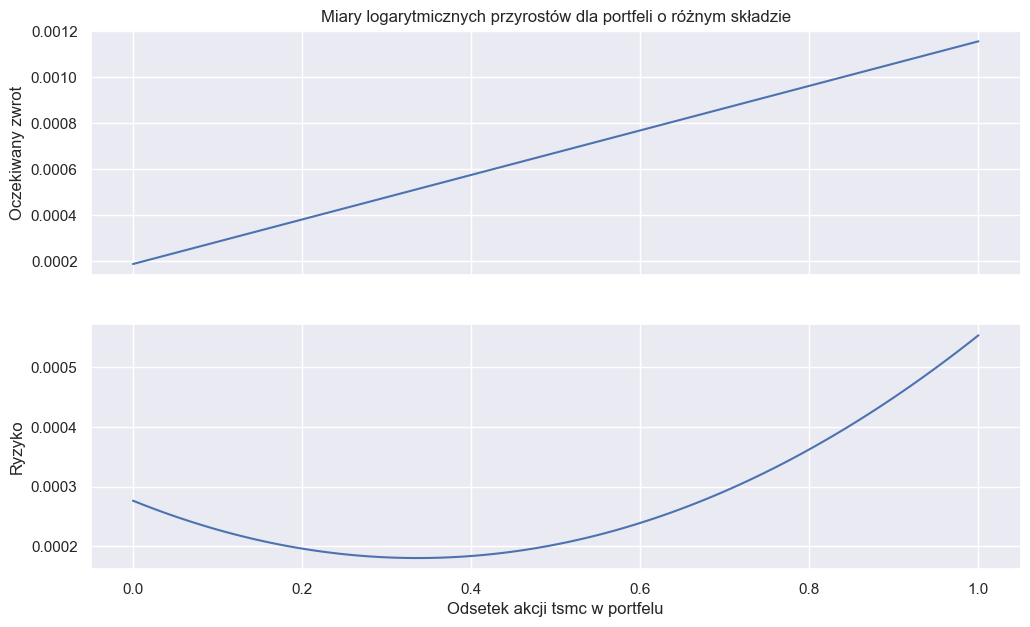

In [40]:


fig, axs = plt.subplots(2,1, sharex=True)
axs[0].plot(space, means)
axs[0].set_ylabel('Oczekiwany zwrot')
axs[0].set_title('Miary logarytmicznych przyrostów dla portfeli o różnym składzie')
axs[1].plot(space, vars)
axs[1].set_ylabel('Ryzyko')
axs[1].set_xlabel('Odsetek akcji tsmc w portfelu')



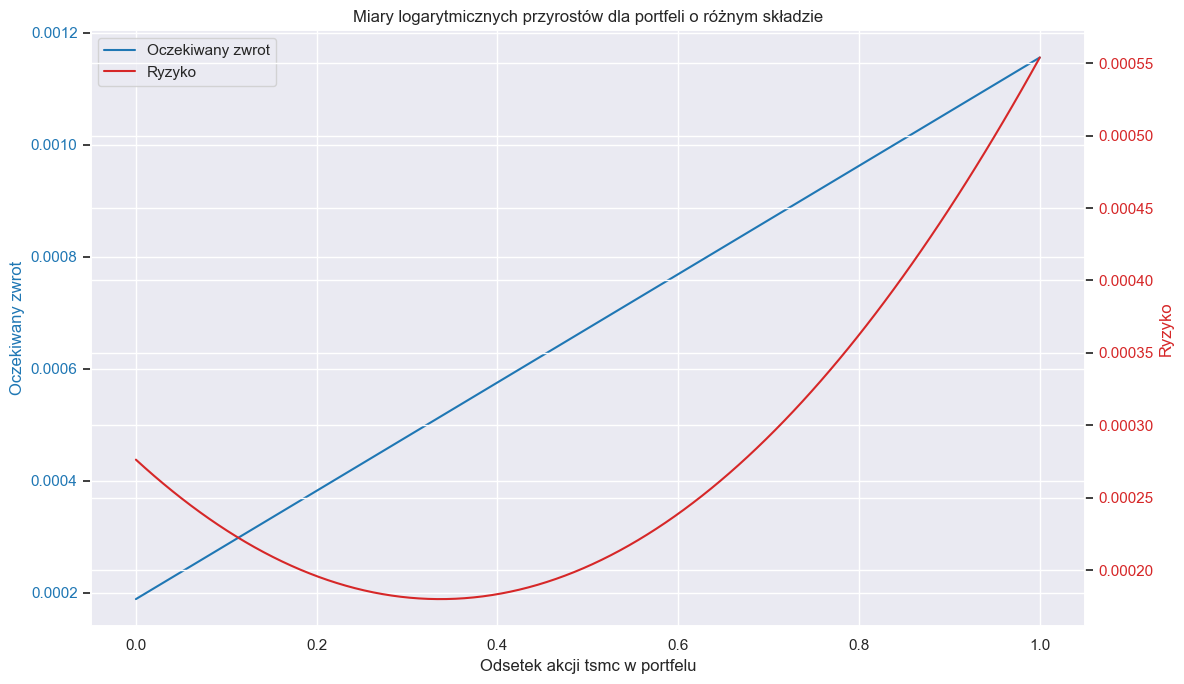

In [41]:
fig, ax1 = plt.subplots()

# Pierwszy wykres — oczekiwany zwrot (lewa oś Y)
ax1.plot(space, means, color='tab:blue', label='Oczekiwany zwrot')
ax1.set_ylabel('Oczekiwany zwrot', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title('Miary logarytmicznych przyrostów dla portfeli o różnym składzie')
ax1.set_xlabel('Odsetek akcji tsmc w portfelu')

# Drugi wykres — ryzyko (prawa oś Y)
ax2 = ax1.twinx()
ax2.plot(space, vars, color='tab:red', label='Ryzyko')
ax2.set_ylabel('Ryzyko', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# (Opcjonalnie) Dodanie wspólnej legendy
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()

In [57]:
print(np.mean(data_comb,axis = 0))
print(np.cov(data_comb.T))
print(np.corrcoef(data_comb.T))

[0.00115554 0.00018896]
[[ 5.54345258e-04 -9.72684622e-06]
 [-9.72684622e-06  2.76498109e-04]]
[[ 1.         -0.02484482]
 [-0.02484482  1.        ]]


In [44]:
print(data_comb[:,0].mean(),data_comb[:,1].mean())

0.001155538433565451 0.00018896418590254918
